https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [12]:
#Import libs
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM,Activation,Dense,Dropout,Input,Embedding

from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping


In [13]:
spam = pd.read_csv('spam.csv',encoding='latin-1')
spam.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [14]:
X=spam.v2
Y=spam.v1

Y

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5572, dtype: object

In [15]:
#Label encoding the label
le=LabelEncoder()

Y=le.fit_transform(Y)
print(Y)

[0 0 1 ... 0 0 0]


In [16]:
#split into train and test 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15) #testing data is 15%
X_train.shape

(4736,)

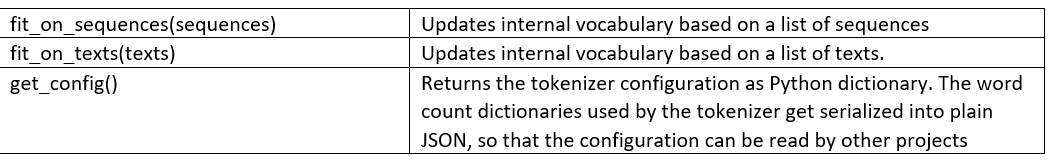

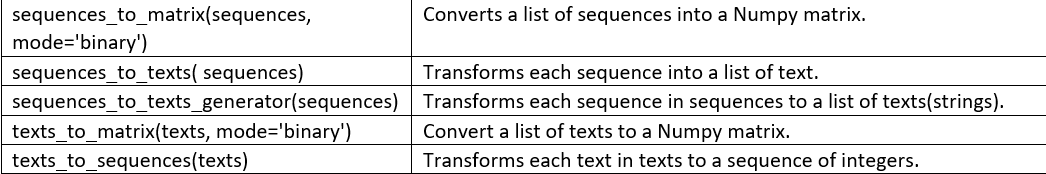

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [17]:
#converting sentences into vectors 
#tokenizer

max_words=1000 


#updates the internal vocabulory with X_train data
tok=Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

#converts each text in train data into sequence of integers
sequences=tok.texts_to_sequences(X_train)
print(sequences)


[[1, 69, 833, 144, 36, 7], [22, 3, 45, 12, 5, 1, 54, 1, 60], [1, 744, 20, 49, 89, 153, 132, 172, 129, 1, 56, 45, 705, 165, 147, 6, 65, 834, 207, 40, 8, 11, 835, 38, 745], [46, 1, 60, 4, 7, 35, 670, 3, 30, 7], [36, 12, 418, 33, 3, 216, 232, 5, 505, 8, 25, 4, 23, 84, 48, 15, 436], [5, 14, 8, 25, 44, 39, 338, 640, 348, 241, 24, 403, 15, 8, 44, 39, 338, 241, 17, 4, 222, 470, 895], [283, 85, 548, 38, 38, 48, 20, 89, 385, 264], [190, 13, 105, 38, 178, 4, 789, 437, 612, 896, 146, 19, 897, 40, 8, 5, 386, 549, 2, 419, 3, 16, 898, 366], [248, 332, 212, 310, 339, 102, 132, 1, 216, 899, 75], [224, 230, 1, 35, 16, 3], [900, 169, 550, 3, 2, 11, 71, 32, 471, 7, 340, 367, 2, 420, 50, 6, 706, 217, 130, 90, 83, 2, 349], [38, 80, 2, 249, 128, 506, 296, 268, 14, 40], [39, 25, 641, 253, 46, 82, 61, 39, 49, 89, 341, 6, 268], [125, 57, 1, 62, 707, 7, 72, 14, 5, 323, 790, 8, 86, 19, 11, 106, 33, 3, 69, 1, 26, 71, 123, 7, 84, 33, 404, 191], [150, 50, 1, 60, 29, 19, 3, 26, 106, 10, 115, 73, 1, 17, 4, 106, 75, 1

**tf.keras.preprocessing.sequence.pad_sequences**

This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape

In [18]:
#transform the integers into 2d numpy array
max_len=150

sequences_matrix=sequence.pad_sequences(sequences,maxlen=max_len)
sequences_matrix

array([[  0,   0,   0, ..., 144,  36,   7],
       [  0,   0,   0, ...,  54,   1,  60],
       [  0,   0,   0, ..., 835,  38, 745],
       ...,
       [  0,   0,   0, ..., 433,   1,  31],
       [  0,   0,   0, ..., 141, 100,  16],
       [  0,   0,   0, ...,  59,   2,  31]])

# Building RNN

In [20]:
def RNN():
    inputs=Input(name='inputs',shape=[max_len])
    layer=Embedding(max_words,50,input_length=max_len)(inputs)
    
    layer=LSTM(64)(layer)
    layer=Dense(256,name='FC1')(layer)
    layer=Activation('relu')(layer)
    layer=Dropout(0.5)(layer)#improvisation of model using dropouts
    layer=Dense(1,name='out_layer')(layer) #final fully connected dense layer
    
    layer=Activation('sigmoid')(layer) #output layer
    
    model=Model(inputs=inputs,outputs=layer)
    return model


model=RNN()
model.summary()
    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

# Training

In [23]:
#input is sequences_matrix
#label is Y_train
#validation split is 0.2
#Early stopping callbacks will stop as per the validation loss-when highest will stop

model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 5s 138ms/step - loss: 0.0834 - accuracy: 0.9807 - val_loss: 0.0569 - val_accuracy: 0.9873


The accuracy is 98%